In [2]:
from markov_chain import SimpleSymmetricRandomWalk, get_samples_from_mean_estimator_for_inverse_square, inverse_square
from bootstrap import rbb_parallel_apply_async, regeneration_based_bootstrap_parallel_apply_async
from utils import get_normalized_mean_statistic
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Prepare style for the plots
sns.set_style("whitegrid")
sns.set_context("paper")
my_green = (0/255, 128/255, 0)

In [4]:
# Random seed for reproducibility
random_seed = 2024
np.random.seed(random_seed)

In [5]:
# Variables
num_samples_true_dist = 10**5
n_bootstraps = 10**4  # Number of bootstraps to perform
true_mean = (np.pi**2)/3

In [6]:
sizes =[10**3, 5*10**3, 10**4, 5*10**4, 10**5, 5*10**5, 10**6]

In [7]:
estimator_values = {}
for n_steps in sizes:
    print(n_steps)
    random_seed+=1
    val = get_samples_from_mean_estimator_for_inverse_square(num_samples=num_samples_true_dist, markov_chain_class=SimpleSymmetricRandomWalk, create_kargs={"step_n": n_steps, "name":"simple_rw"}, true_mean=true_mean, atom_state=0, random_seed=random_seed)
    estimator_values[n_steps] = val

1000


5000
10000
50000
100000
500000
1000000


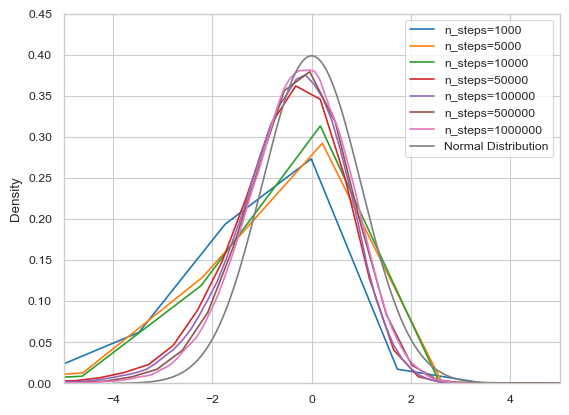

In [11]:
for k, v in estimator_values.items():
    sns.kdeplot(data=v, label=f"n_steps={k}")
# Define the mean and standard deviation for the normal distribution
mean = 0
std_dev = 1

# Generate x values
x = np.linspace(mean - 4*std_dev, mean + 4*std_dev, 1000)

# Calculate the PDF of the normal distribution
pdf = (1/(std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std_dev)**2)

# Plot the PDF of the normal distribution
plt.plot(x, pdf, label="Normal Distribution")
plt.xlim(-5, 5)
plt.ylim(0, 0.45)
plt.legend()
plt.show()


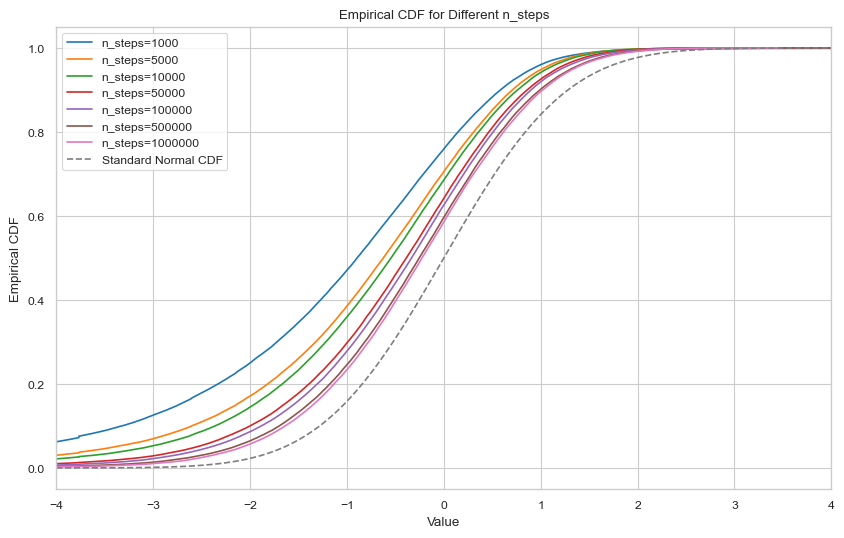

In [12]:
# Function to compute empirical CDF
def empirical_cdf(data):
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, cdf

# Plot the empirical CDF for each value in estimator_values
plt.figure(figsize=(10, 6))
for n_steps, values in estimator_values.items():
    sorted_data, cdf = empirical_cdf(values)
    plt.plot(sorted_data, cdf, label=f"n_steps={n_steps}")

# Plot the CDF of a standard normal distribution
from scipy.stats import norm

x = np.linspace(-4, 4, 1000)
cdf_standard_normal = norm.cdf(x)
plt.plot(x, cdf_standard_normal, label="Standard Normal CDF", linestyle='--')

plt.xlabel('Value')
plt.xlim(-4,4)
plt.ylabel('Empirical CDF')
plt.title('Empirical CDF for Different n_steps')
plt.legend()
plt.grid(True)
plt.show()

In [51]:
random_seed=2032

In [52]:
rbb_plot_kwargs = {"linestyle": '--', "linewidth": 2}
regeneration_based_plot_kwargs = {"linestyle": ':', "linewidth": 2}

1000
2033


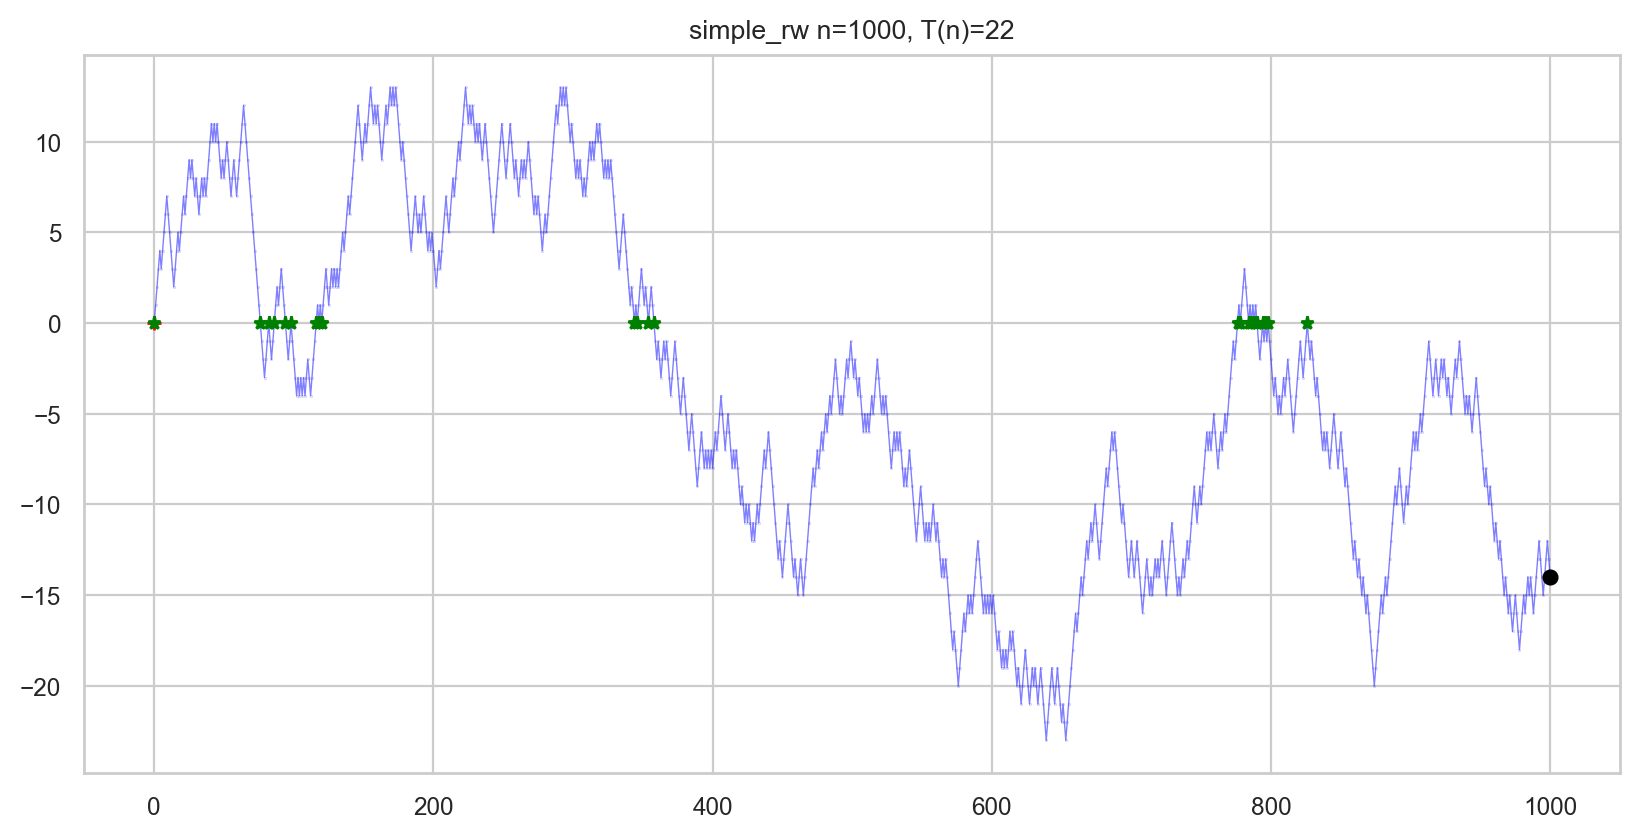

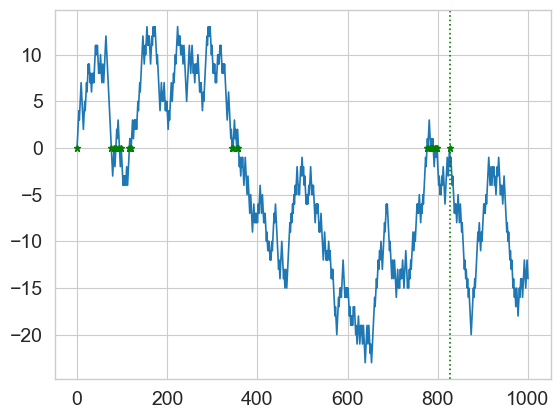

r=0.6957010852370434
T(n)=22


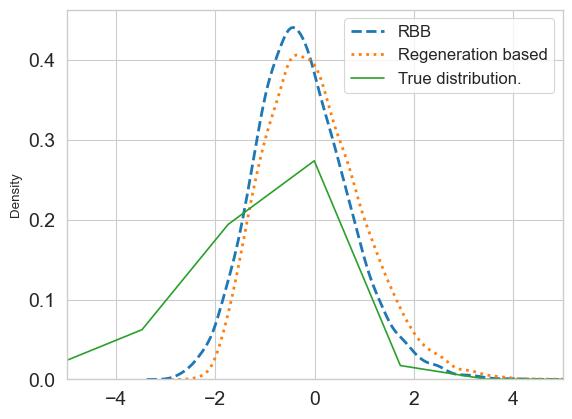

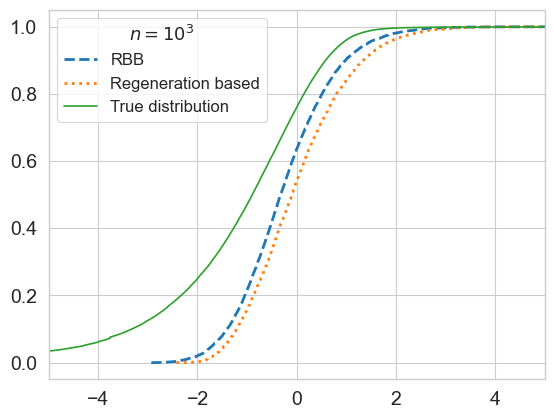

5000
2034


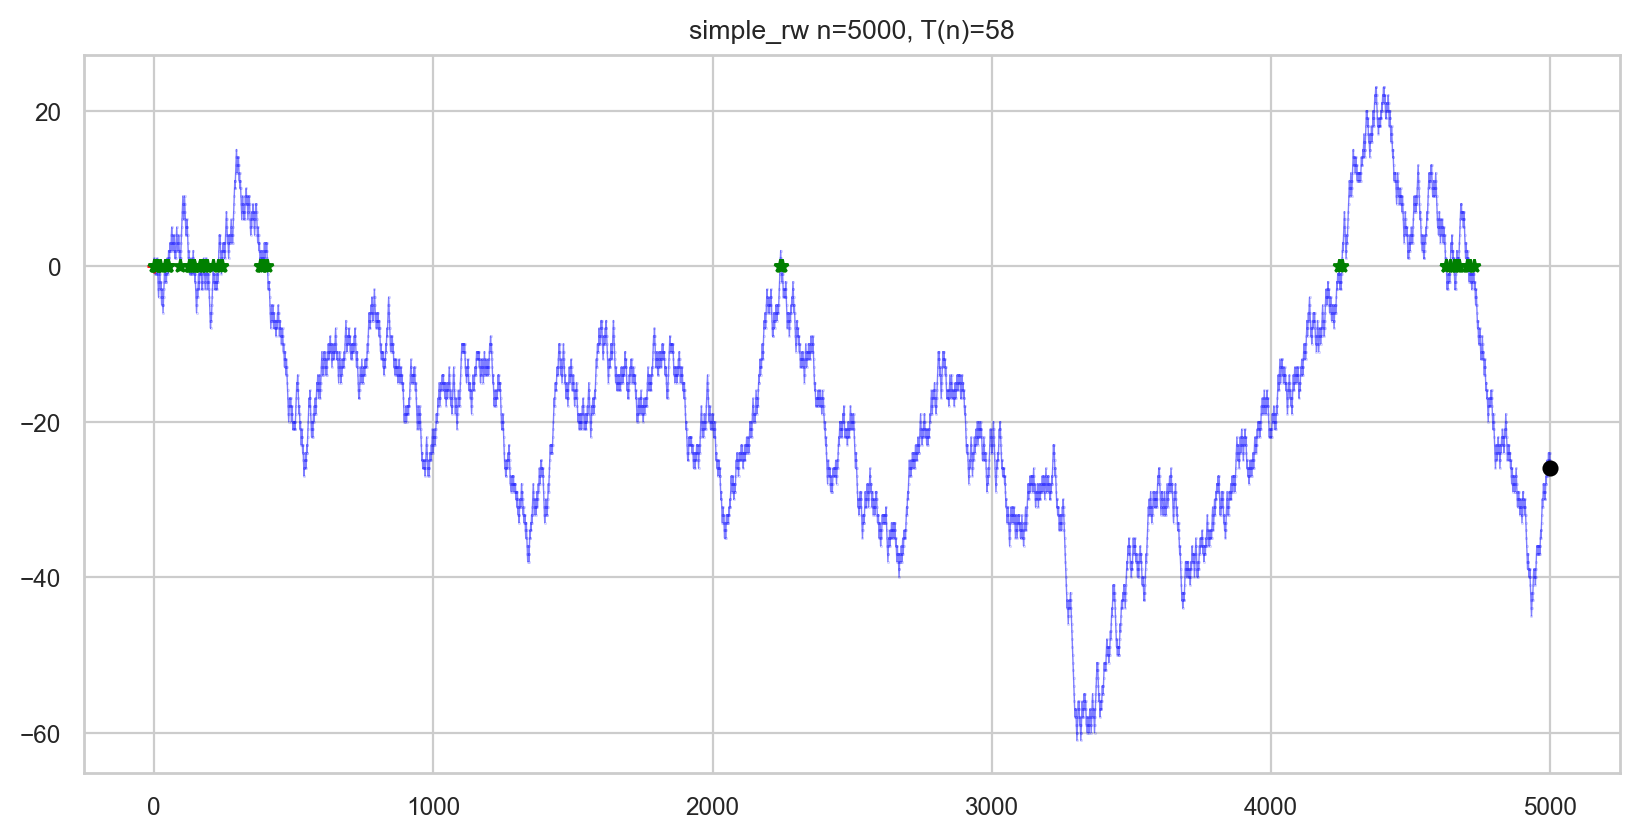

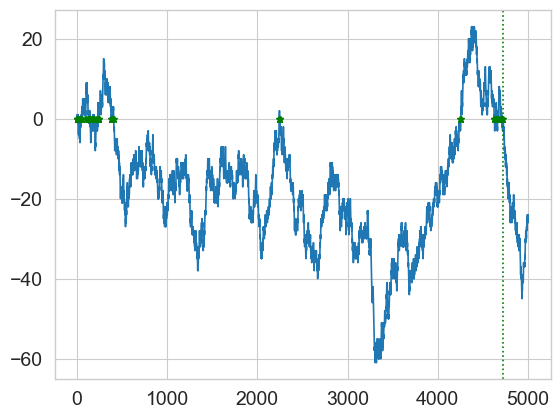

r=0.8202438661763951
T(n)=58


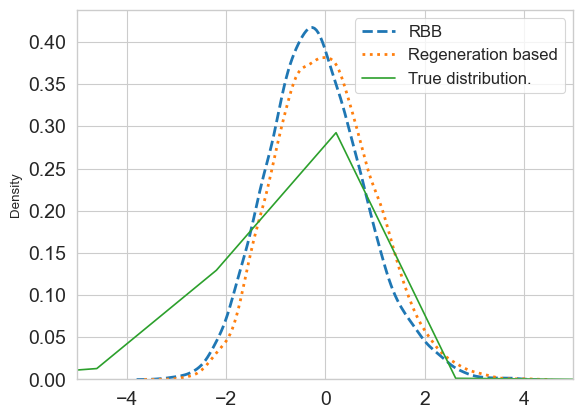

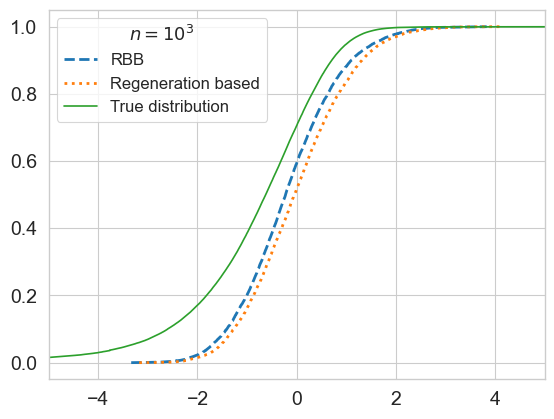

10000
2035
2036
2037


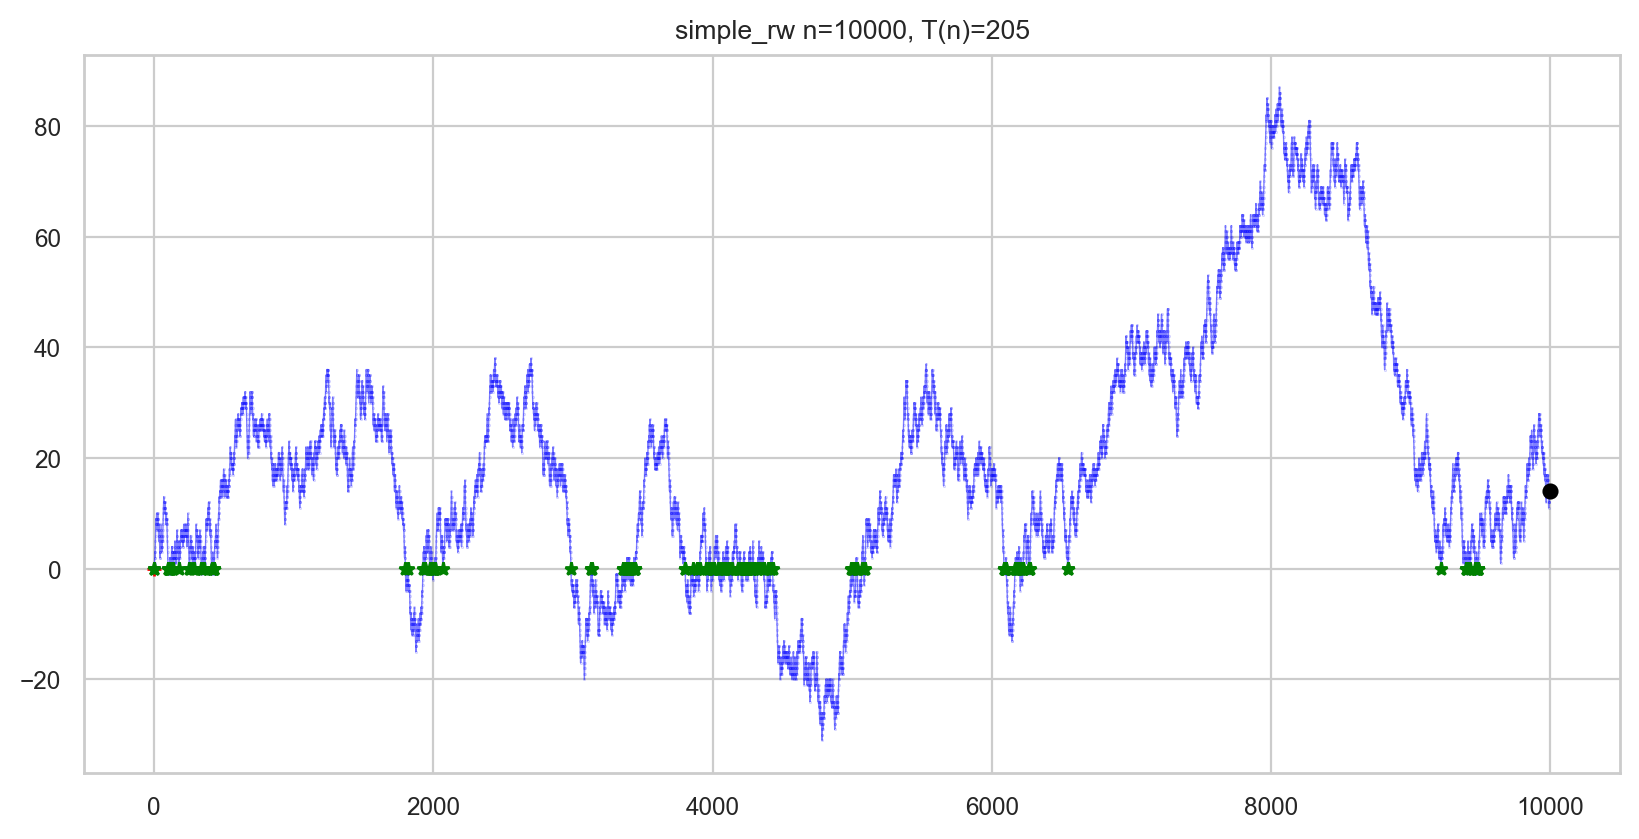

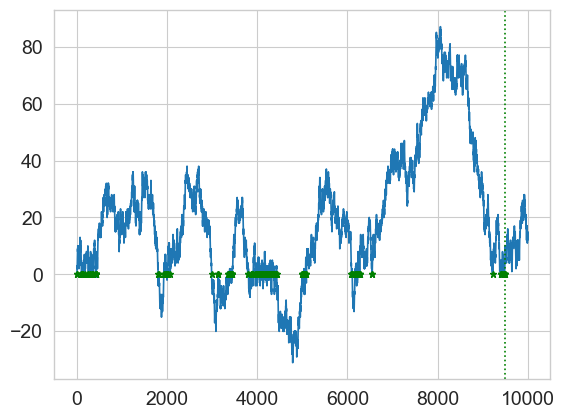

r=2.05
T(n)=205


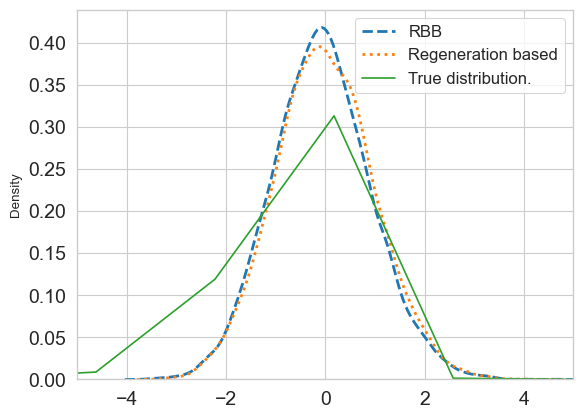

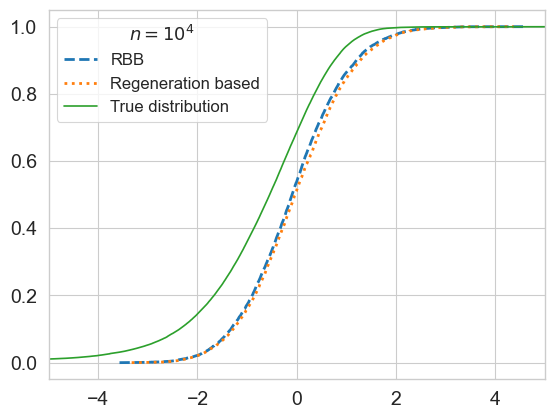

50000
2038


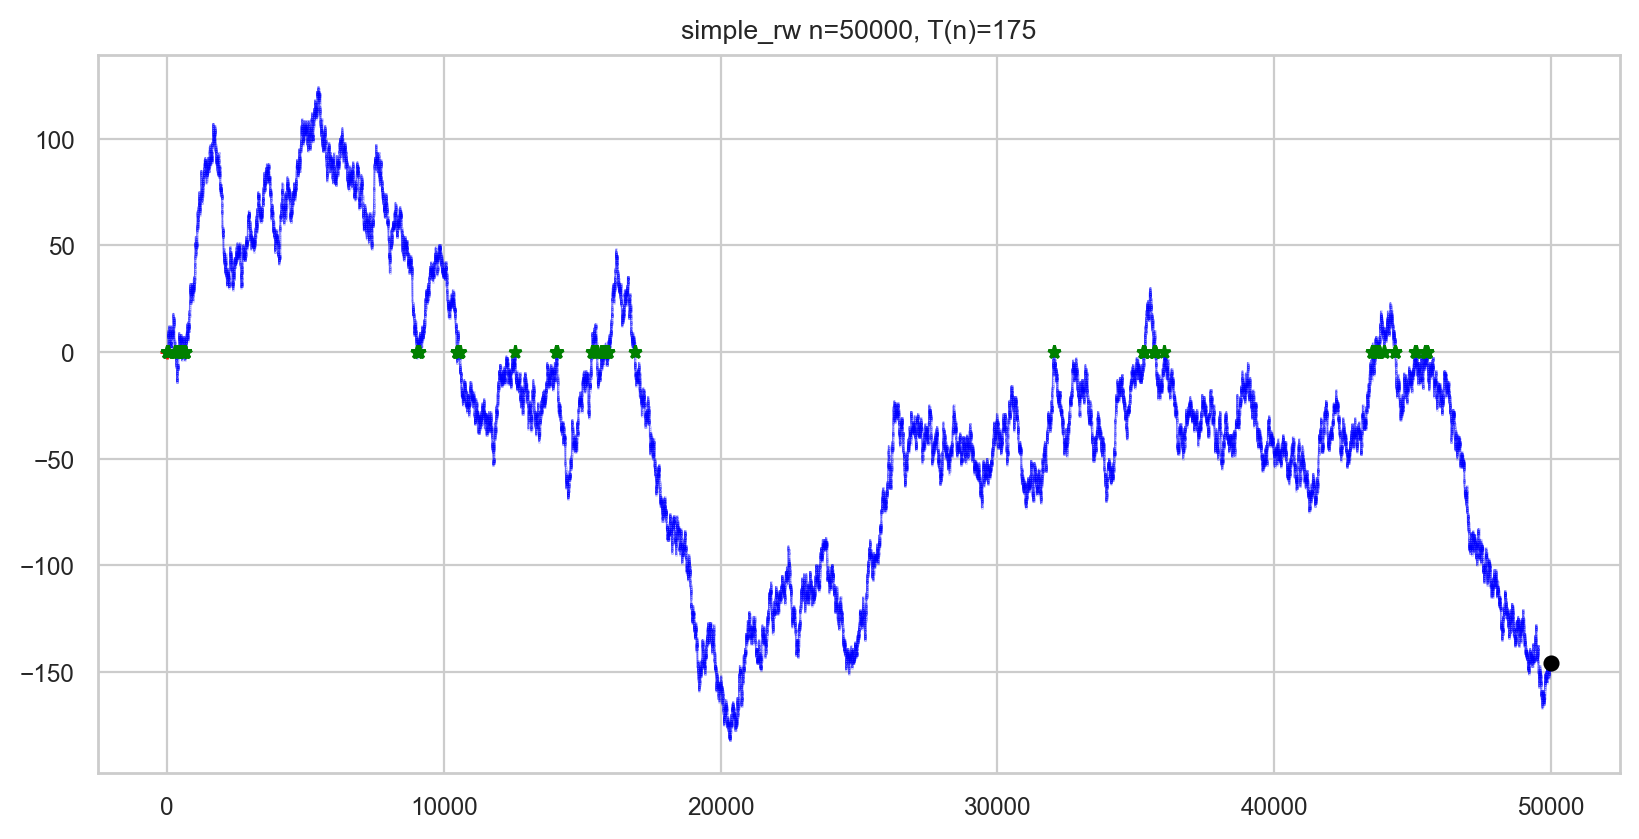

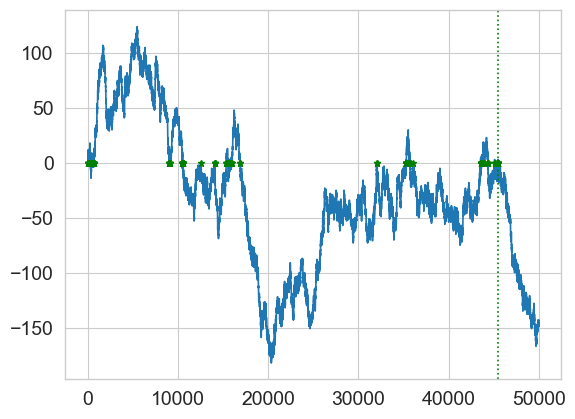

r=0.7826237921249264
T(n)=175


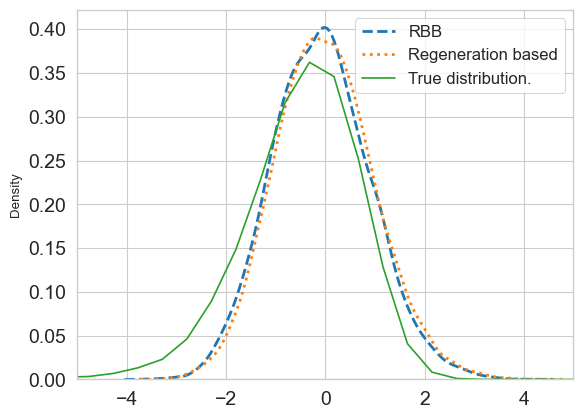

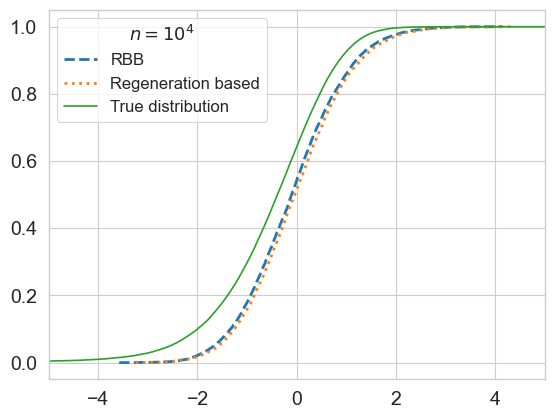

100000
2039
2040
2041


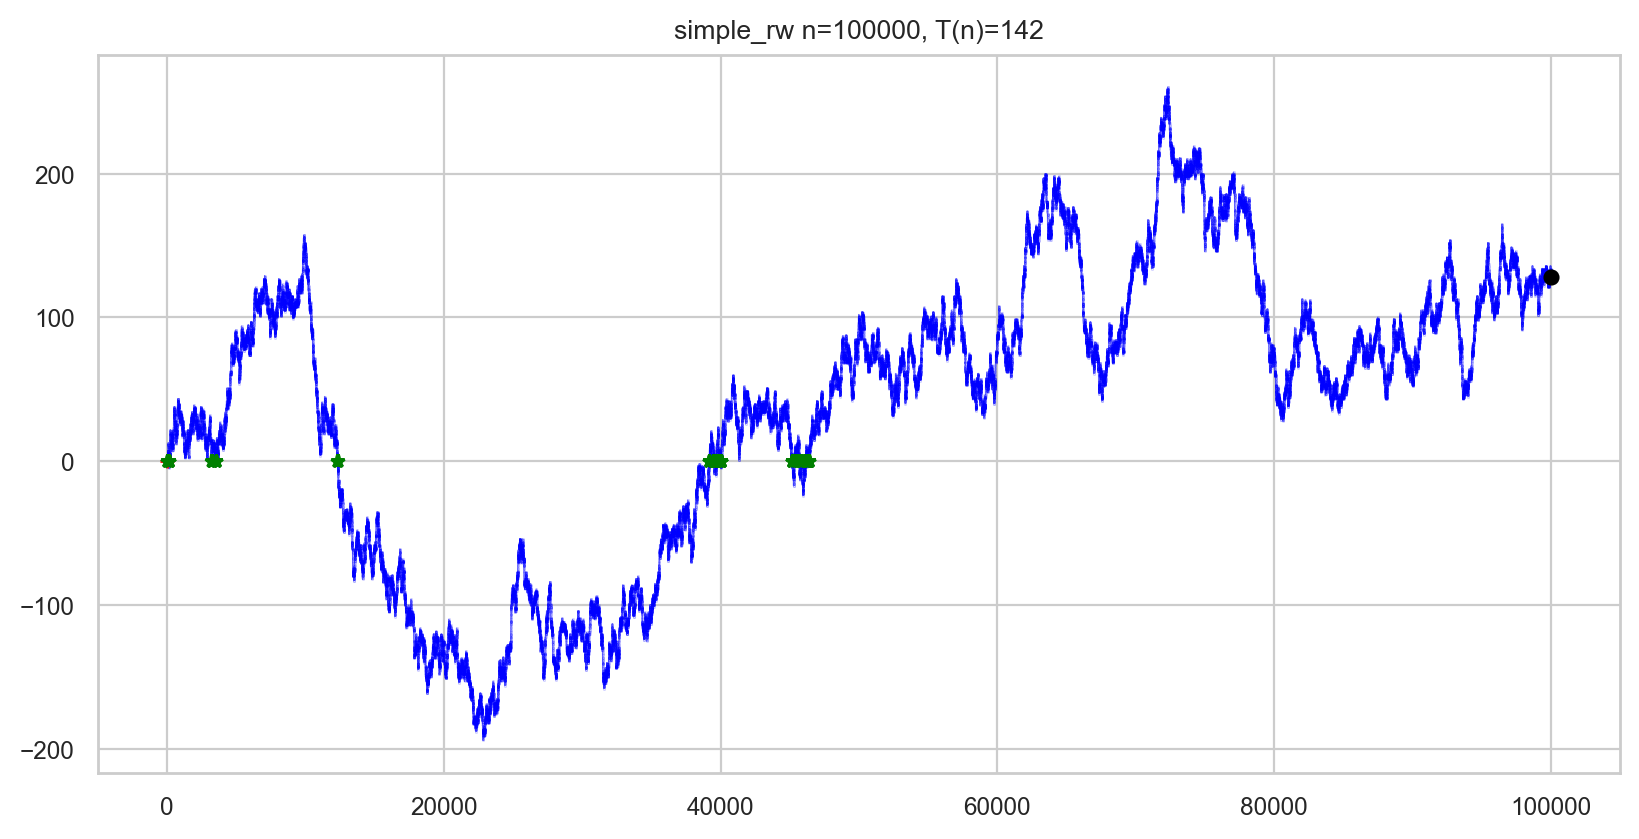

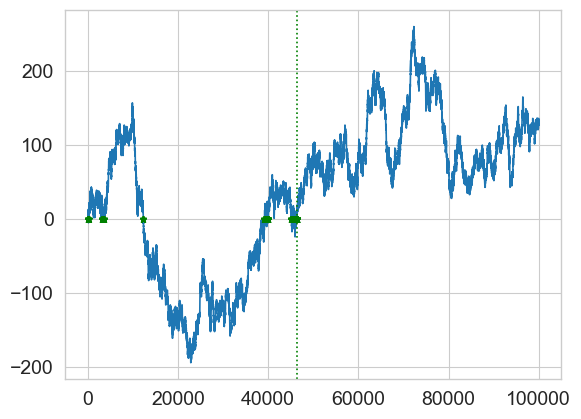

r=0.4490434277439098
T(n)=142


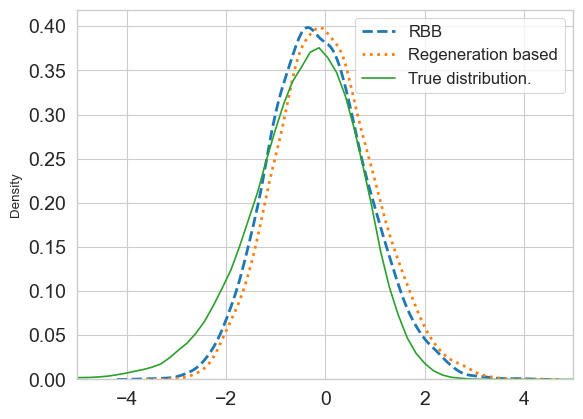

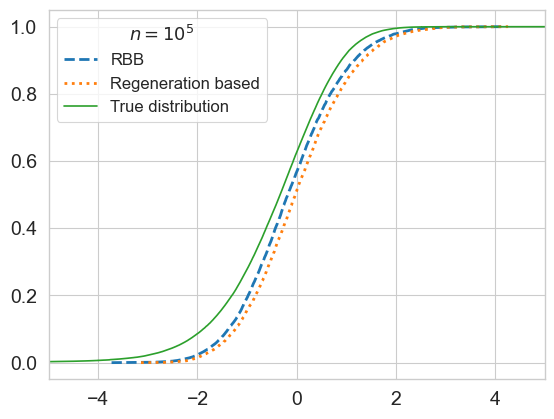

500000
2042
2043


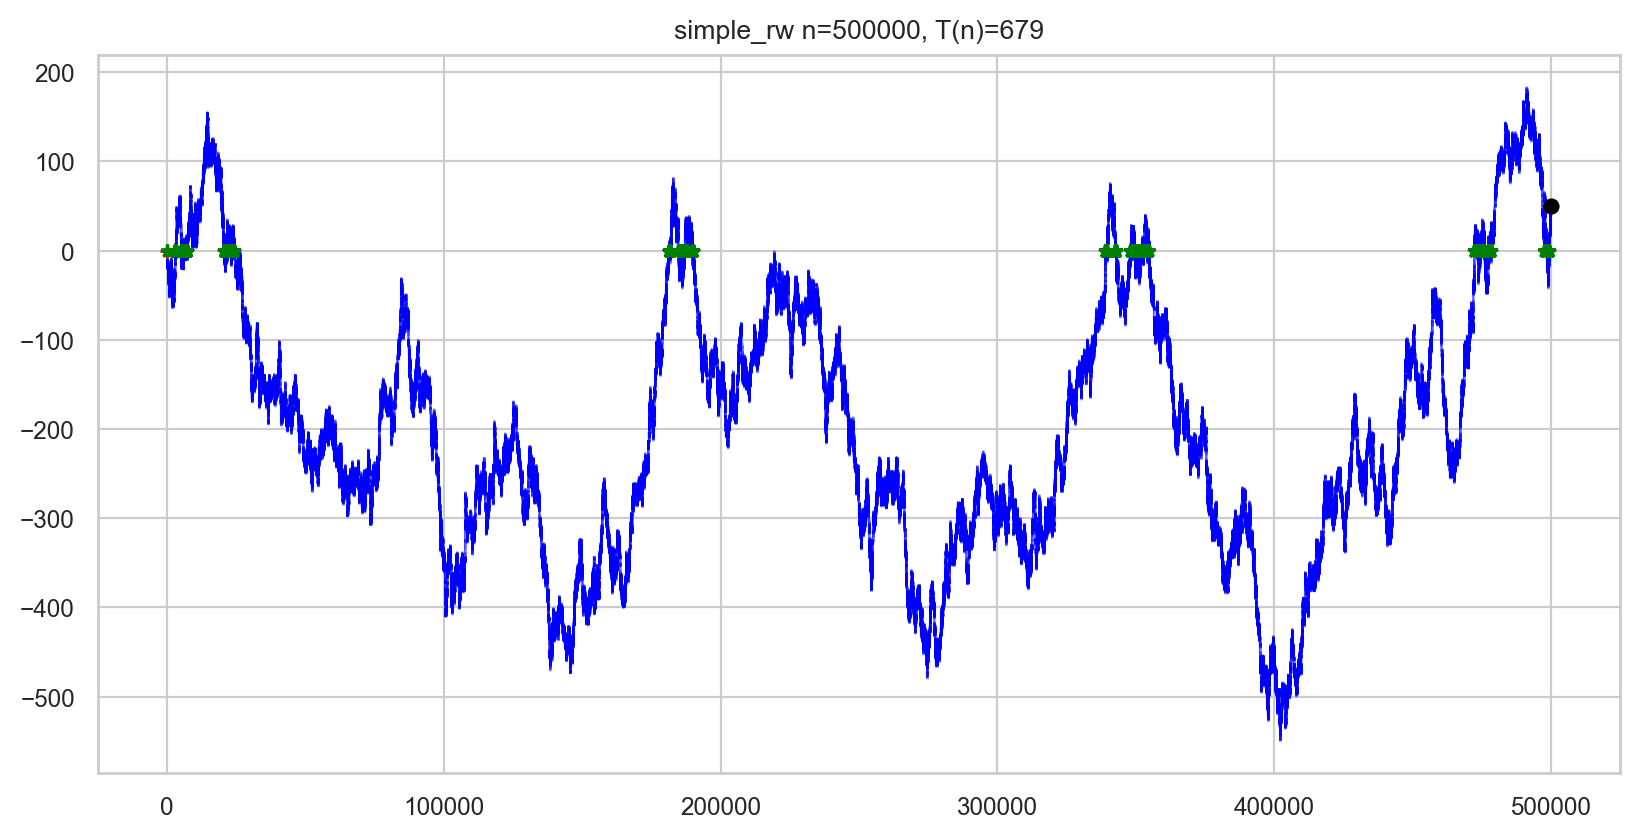

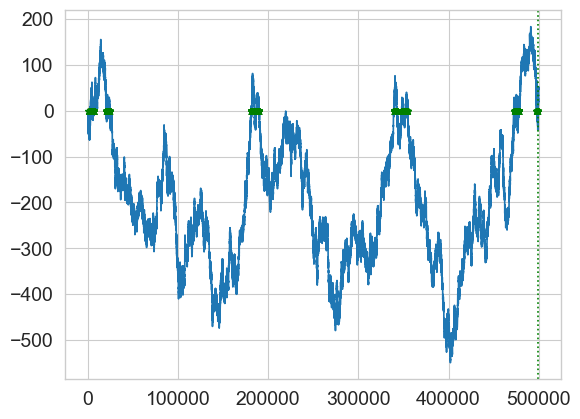

r=0.9602510088513315
T(n)=679


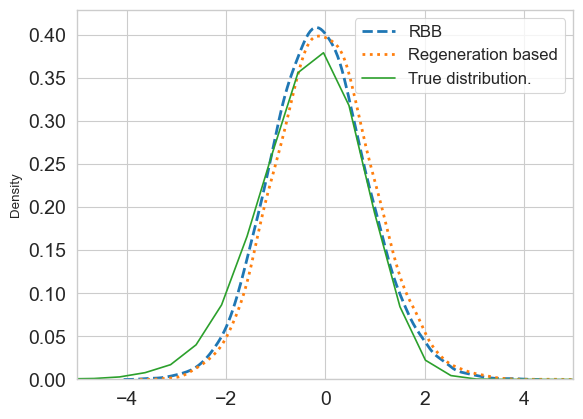

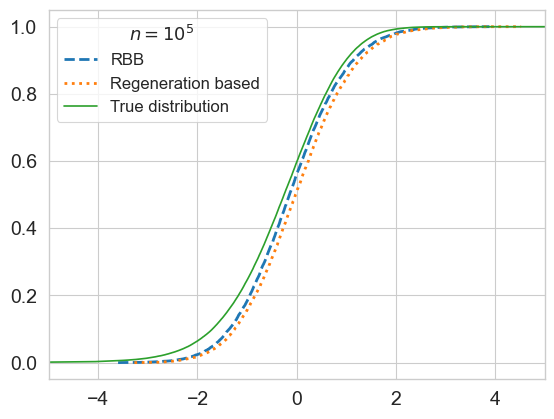

1000000
2044
2045


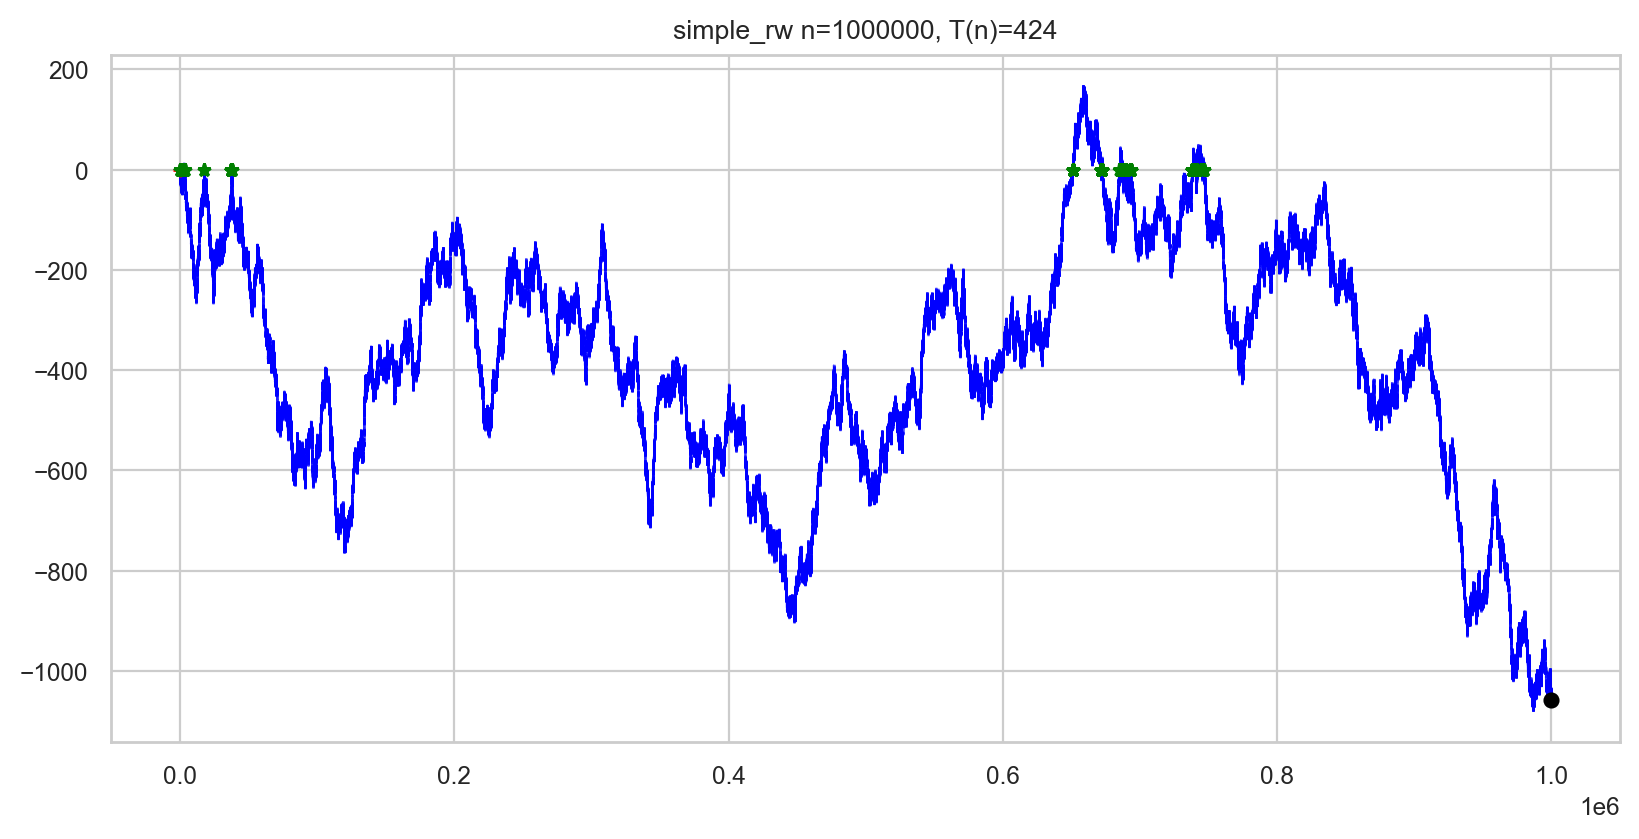

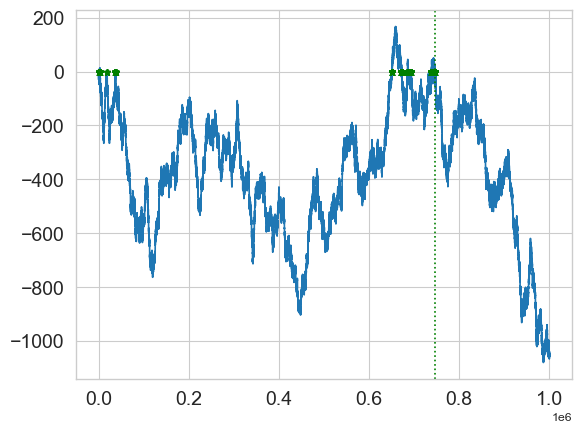

r=0.424
T(n)=424


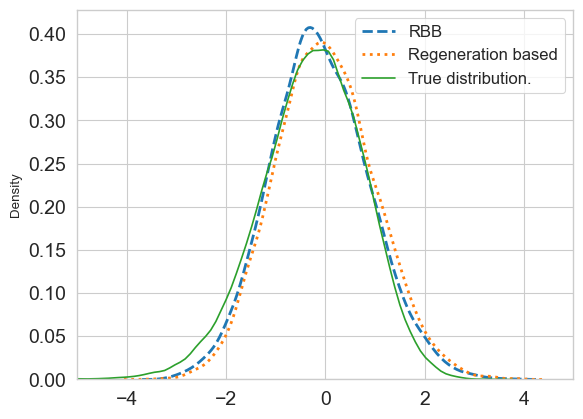

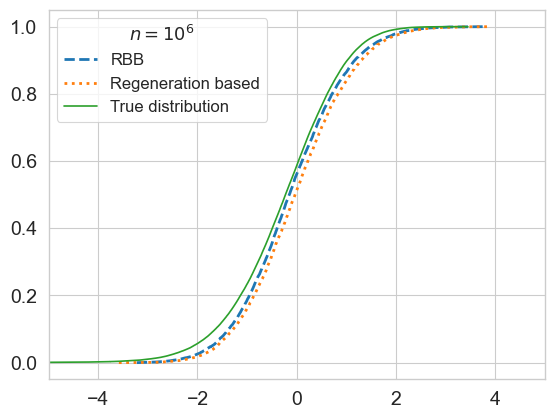

In [53]:
for n_steps in sizes:
    print(n_steps)
    while True:
        random_seed+=1
        print(random_seed)
        ssrw = SimpleSymmetricRandomWalk(
                    step_n=n_steps, name=f"simple_rw", random_seed=random_seed
                )
        ssrw.generate_path()
        # Get regeneration block sizes
        regeneration_block_sizes = ssrw.get_regeneration_block_sizes(state=0)
        # Get the value of the function evaluated on the blocks
        fn_blocks = ssrw.apply_fn_regeneration_blocks(state=0, fn=inverse_square)
        if np.sum(regeneration_block_sizes) > 0.4*n_steps and np.std(fn_blocks) > 0:
            break
    ssrw.plot_simulation(state=0, save=False)

    times_of_visit = ssrw.get_times_of_visits(state=0)

    biggest_block_index = np.argmax(regeneration_block_sizes==max(regeneration_block_sizes))
    biggest_block_start = times_of_visit[biggest_block_index]
    biggest_block_end = times_of_visit[biggest_block_index+1]
    plt.plot(ssrw.get_path())
    # plt.axvline(x=biggest_block_start, color='r', linestyle='--')
    # plt.axvline(x=biggest_block_end, color='r', linestyle='--')
    plt.axvline(x=max(times_of_visit), color=my_green, linestyle='dotted')

    for c_p in times_of_visit:
        plt.plot(c_p, 0, c="green", marker="*")
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

    fn_rbb_bootstraps = rbb_parallel_apply_async(block_sizes=regeneration_block_sizes, block_values=fn_blocks, n=n_steps, num_bootstraps=n_bootstraps)
    r = len(fn_blocks)/np.sqrt(n_steps)
    da = [get_normalized_mean_statistic(fn_blocks=fn_rbb_bootstraps, mean=np.mean(fn_blocks), standard_dev=np.std(fn_blocks)) for fn_rbb_bootstraps in fn_rbb_bootstraps]
    fn_regeneration_based_bootstraps= regeneration_based_bootstrap_parallel_apply_async(block_values=fn_blocks, num_bootstraps=n_bootstraps)
    daa = [get_normalized_mean_statistic(fn_blocks=fn_regeneration_based_bootstrap, mean=np.mean(fn_blocks), standard_dev=np.std(fn_blocks)) for fn_regeneration_based_bootstrap in fn_regeneration_based_bootstraps]
    sns.kdeplot(data=da, label="RBB", **rbb_plot_kwargs)
    sns.kdeplot(data=daa, label="Regeneration based", **regeneration_based_plot_kwargs)
    sns.kdeplot(data=estimator_values[n_steps], label=fr"True distribution.")
    print(f"r={r}")
    print(f"T(n)={len(fn_blocks)}")
    # plt.title(rf'Single realization. n={n_steps} $\frac{{T(n)}}{{\sqrt{{n}}}}={r:.2f}$')
    plt.legend(loc='best', fontsize=12)
    plt.xlim(-5,5)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

    sorted_data, cdf = empirical_cdf(da)
    plt.plot(sorted_data, cdf, label=f"RBB", **rbb_plot_kwargs)
    sorted_data, cdf = empirical_cdf(daa)
    plt.plot(sorted_data, cdf, label=f"Regeneration based", **regeneration_based_plot_kwargs)
    sorted_data, cdf = empirical_cdf(estimator_values[n_steps])
    plt.plot(sorted_data, cdf, label=f"True distribution")
    exponent = int(np.log10(n_steps))
    # plt.title(rf'Comparison of distribution functions. n={n_steps}', fontsize=16)
    plt.legend(loc='best', fontsize=12, title=rf"$n=10^{{{exponent}}}$", title_fontsize=13)
    plt.xlim(-5,5)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()
